# 1. Importar librerías

In [5]:
#Librerías para manipulación de datos
import pandas as pd
import numpy as np

#Librerías para visualización
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate,GridSearchCV

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier

from sklearn.feature_selection import SelectKBest, f_classif,chi2

#Importar módulo de funciones
import sys
sys.path.insert(0, 'utils')  # Añadir el directorio 'utils' al PATH
import funciones
from importlib import reload
reload(funciones)  # Recarga el módulo

pd.set_option('display.max_columns',None)

# 2. Importar datos


In [6]:
df = pd.read_csv('data/data_2015_clean.csv', dtype={'StockOptionLevel': str, 'JobLevel': str, 'NumCompaniesWorked': 'int64'})

In [7]:
df.head()

,InfoDate,EmployeeID,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TrainingTimesLastYear,YearsAtCompany,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,BusinessTravel,Department,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,retirementType,resignationReason,Attrition,retirementDate,JobInvolvement,PerformanceRating
0,2015-12-31,2532,32,9,43270,8,13,0,4,0,4,4,4,Travel_Frequently,Sales,Master,Life Sciences,Male,4,Sales Executive,Single,NaN,NaN,No,NaN,3,3
1,2015-12-31,1062,32,9,43270,8,13,0,4,0,4,4,4,Travel_Frequently,Sales,Master,Life Sciences,Male,4,Sales Executive,Single,NaN,NaN,No,NaN,3,3
2,2015-12-31,4002,32,9,43270,8,13,0,4,0,4,4,4,Travel_Frequently,Sales,Master,Life Sciences,Male,4,Sales Executive,Single,NaN,NaN,No,NaN,3,3
3,2015-12-31,421,48,1,21770,4,18,0,4,0,4,3,2,Travel_Rarely,Research & Development,Master,Medical,Male,1,Research Scientist,Married,NaN,NaN,No,NaN,3,3
4,2015-12-31,1891,48,1,21770,4,18,0,4,0,4,3,2,Travel_Rarely,Research & Development,Master,Medical,Male,1,Research Scientist,Married,NaN,NaN,No,NaN,3,3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4353 entries, 0 to 4352
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   InfoDate                 4353 non-null   object
 1   EmployeeID               4353 non-null   int64 
 2   Age                      4353 non-null   int64 
 3   DistanceFromHome         4353 non-null   int64 
 4   MonthlyIncome            4353 non-null   int64 
 5   NumCompaniesWorked       4353 non-null   int64 
 6   PercentSalaryHike        4353 non-null   int64 
 7   StockOptionLevel         4353 non-null   object
 8   TrainingTimesLastYear    4353 non-null   int64 
 9   YearsAtCompany           4353 non-null   int64 
 10  EnvironmentSatisfaction  4353 non-null   int64 
 11  JobSatisfaction          4353 non-null   int64 
 12  WorkLifeBalance          4353 non-null   int64 
 13  BusinessTravel           4353 non-null   object
 14  Department               4353 non-null  

# 2. Preparación de datos

## 2.1. Obtener dummies y Escalar

In [9]:
df_no_trans = df.drop(['Attrition','retirementDate','retirementType','resignationReason','InfoDate','EmployeeID'], axis=1)

num_columns = df_no_trans.select_dtypes('int64').columns
cat_columns = df_no_trans.select_dtypes('object').columns

In [10]:
# Crear un ColumnTransformer para aplicar transformaciones específicas a las columnas
transformer = ColumnTransformer([('num',StandardScaler(), num_columns),
                                 ('cat', OneHotEncoder(), cat_columns)])

# Ajustar y transformar el DataFrame
df_transformado = transformer.fit_transform(df_no_trans)

In [11]:
columns_transformed = transformer.get_feature_names_out(df_no_trans.columns)

In [12]:
df2 = pd.DataFrame(df_transformado, columns = columns_transformed)
df2['target'] = df['Attrition'].replace({'Sí':1, 'No':0})

# 2.2. Separar variable objetivo de los datos

In [13]:
X = df2.drop('target',axis=1)
y = df2['target']

print(X.shape)
print(y.shape)

(4353, 52)
(4353,)


# 3. Selección de variables

## 3.1. SelectKBest

#### Anova

In [14]:
def select_kbest(X,y,score_f,k):
    sel_kb = SelectKBest(score_func = score_f,k = k)
    sel_kb.fit(X,y)
    new_cols= sel_kb.get_support()
    print('Score:\n', sel_kb.scores_, '\n P-values:\n', sel_kb.pvalues_)
    return new_cols

In [15]:
X_new = select_kbest(X, y, f_classif, 30)
# Nuevo conjunto de datos
df_anova = X.iloc[:,X_new]
df_anova.head()

Score:
 [9.36130542e+01 8.12374511e-03 1.94697108e+00 7.74182132e+00
 8.61684071e-01 1.03433937e+01 8.27399526e+01 3.18519561e+01
 4.78817564e+01 1.60290245e+01 1.69900005e+00 2.13286553e-01
 8.66151432e-02 2.51847682e+00 3.81317628e+00 1.30427920e-02
 1.65972031e+01 5.49753660e+01 1.33219287e+01 2.54680775e+01
 3.81552795e-01 2.53004278e+00 1.26661207e-01 6.57734788e-01
 5.17716730e+00 8.67680128e-01 4.50114767e-01 3.28362502e+01
 2.22998544e-01 1.41703332e-02 4.18179343e-02 2.97912298e+00
 2.80247805e+00 8.73949656e-01 8.73949656e-01 4.73668596e-02
 1.33551718e+00 6.21605497e-01 8.10896097e-02 1.30442291e+00
 6.30794492e-01 6.33811679e-01 1.07594314e-01 3.81957900e+00
 4.97271525e+00 4.35070875e+00 1.53682556e+00 2.06748666e+00
 4.87580155e-01 2.15360395e+01 3.01900480e+01 1.01679456e+02] 
 P-values:
 [6.36980385e-22 9.28186611e-01 1.62984831e-01 5.41889701e-03
 3.53319336e-01 1.30890042e-03 1.39313799e-19 1.76955557e-08
 5.18768864e-12 6.34183618e-05 1.92487766e-01 6.44226632e-01
 7

,num__Age,num__MonthlyIncome,num__NumCompaniesWorked,num__TrainingTimesLastYear,num__YearsAtCompany,num__EnvironmentSatisfaction,num__JobSatisfaction,num__WorkLifeBalance,num__JobInvolvement,cat__StockOptionLevel_1,cat__StockOptionLevel_2,cat__BusinessTravel_Non-Travel,cat__BusinessTravel_Travel_Frequently,cat__BusinessTravel_Travel_Rarely,cat__Department_Human Resources,cat__Department_Sales,cat__Education_College,cat__EducationField_Human Resources,cat__EducationField_Other,cat__EducationField_Technical Degree,cat__JobLevel_2,cat__JobLevel_5,cat__JobRole_Manager,cat__JobRole_Manufacturing Director,cat__JobRole_Research Director,cat__JobRole_Research Scientist,cat__JobRole_Sales Executive,cat__MaritalStatus_Divorced,cat__MaritalStatus_Married,cat__MaritalStatus_Single
0,-0.52393,-0.467319,2.118864,0.930621,-1.238141,1.172225,1.147029,1.758285,0.381187,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.52393,-0.467319,2.118864,0.930621,-1.238141,1.172225,1.147029,1.758285,0.381187,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.52393,-0.467319,2.118864,0.930621,-1.238141,1.172225,1.147029,1.758285,0.381187,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.25567,-0.922516,0.518896,0.930621,-1.238141,1.172225,0.239538,-1.083302,0.381187,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.25567,-0.922516,0.518896,0.930621,-1.238141,1.172225,0.239538,-1.083302,0.381187,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Chi2

In [16]:
df_dummies = pd.get_dummies(df_no_trans)

In [17]:
X_new= select_kbest(df_dummies, y, chi2, 30)
# Nuevo conjunto de datos
df_chi2 = X.iloc[:,X_new]
df_chi2.head()

Score:
 [2.01881006e+02 5.82129840e-02 6.64732132e+04 1.78798873e+01
 7.56779058e-01 6.12871063e+00 3.53400332e+02 1.37519692e+01
 2.10285054e+01 2.86517517e+00 3.14318234e-01 8.76976827e-03
 4.94478816e-02 1.49945199e+00 3.39917001e+00 1.22933417e-02
 1.48658989e+01 4.40953313e+01 3.84610266e+00 2.42316573e+01
 1.32580381e-01 1.76087670e+00 7.75489846e-02 5.81760182e-01
 4.17864553e+00 8.39793157e-01 3.28008799e-01 3.19985631e+01
 1.31147789e-01 1.26330828e-02 2.86312178e-02 2.81423785e+00
 2.55092429e+00 5.25348925e-01 3.48826866e-01 2.99482446e-02
 8.50590130e-01 5.28810581e-01 7.53107345e-02 1.24259171e+00
 5.74025304e-01 6.11726346e-01 8.85757995e-02 3.56011790e+00
 4.47958147e+00 4.11161314e+00 1.23086239e+00 1.61007837e+00
 4.60185548e-01 1.66819816e+01 1.62692562e+01 6.75476045e+01] 
 P-values:
 [8.11640462e-46 8.09343016e-01 0.00000000e+00 2.35294690e-05
 3.84338392e-01 1.33003834e-02 7.70334139e-79 2.08602024e-04
 4.52500748e-06 9.05158546e-02 5.75042354e-01 9.25389541e-01
 8

,num__Age,num__MonthlyIncome,num__NumCompaniesWorked,num__TrainingTimesLastYear,num__YearsAtCompany,num__EnvironmentSatisfaction,num__JobSatisfaction,num__WorkLifeBalance,cat__StockOptionLevel_1,cat__StockOptionLevel_2,cat__BusinessTravel_Non-Travel,cat__BusinessTravel_Travel_Frequently,cat__BusinessTravel_Travel_Rarely,cat__Department_Human Resources,cat__Department_Sales,cat__Education_College,cat__Education_Doctor,cat__EducationField_Human Resources,cat__EducationField_Other,cat__EducationField_Technical Degree,cat__JobLevel_2,cat__JobLevel_5,cat__JobRole_Manager,cat__JobRole_Manufacturing Director,cat__JobRole_Research Director,cat__JobRole_Research Scientist,cat__JobRole_Sales Executive,cat__MaritalStatus_Divorced,cat__MaritalStatus_Married,cat__MaritalStatus_Single
0,-0.52393,-0.467319,2.118864,0.930621,-1.238141,1.172225,1.147029,1.758285,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.52393,-0.467319,2.118864,0.930621,-1.238141,1.172225,1.147029,1.758285,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.52393,-0.467319,2.118864,0.930621,-1.238141,1.172225,1.147029,1.758285,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.25567,-0.922516,0.518896,0.930621,-1.238141,1.172225,0.239538,-1.083302,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.25567,-0.922516,0.518896,0.930621,-1.238141,1.172225,0.239538,-1.083302,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## 3.2. RFE

In [18]:
# Función recursiva de selección de características
def recursive_feature_selection(X, y, model, k):
  rfe = RFE(model, n_features_to_select = k, step = 1)
  fit = rfe.fit(X, y)
  X_new = fit.support_
  print("Num Features: %s" % (fit.n_features_))
  print("Selected Features: %s" % (fit.support_))
  print("Feature Ranking: %s" % (fit.ranking_))

  return X_new

#### Regresión Logística

In [19]:
model= LogisticRegression(max_iter = 1000,random_state = 42)
X_new=recursive_feature_selection(X, y, model, 30)
df_log = X.iloc[:,X_new]
df_log.info()

Num Features: 30
Selected Features: [ True False False  True False  True  True  True  True  True False False
 False  True  True  True  True  True False  True  True  True False False
  True  True False  True False False False  True False False False False
 False False  True  True False  True False  True  True  True False  True
  True  True  True  True]
Feature Ranking: [ 1 20 19  1 18  1  1  1  1  1  8 23 14  1  1  1  1  1  6  1  1  1 13 11
  1  1 12  1 22 16  9  1  7 17 15  2  3 10  1  1 21  1  5  1  1  1  4  1
  1  1  1  1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4353 entries, 0 to 4352
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   num__Age                                4353 non-null   float64
 1   num__NumCompaniesWorked                 4353 non-null   float64
 2   num__TrainingTimesLastYear              4353 non-null   float64
 3   num__YearsAt

#### Bosque Aleatorio

In [20]:
model = RandomForestClassifier(n_estimators=300,random_state=42,n_jobs=-1)
X_new = recursive_feature_selection(X,y,model,30)
df_ranfor = X.iloc[:,X_new]
df_ranfor.info()

Num Features: 30
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True False
  True  True False False False  True False  True  True  True  True False
  True False  True False  True False  True False False  True  True  True
  True False False False False False False False False False  True  True
 False False  True  True]
Feature Ranking: [ 1  1  1  1  1  1  1  1  1  1  1  7  1  1  5 14 18  1  3  1  1  1  1  8
  1 23  1 13  1 12  1 20 16  1  1  1  1  4 10 22 11 21  2 19 15  9  1  1
 17  6  1  1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4353 entries, 0 to 4352
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   num__Age                                4353 non-null   float64
 1   num__DistanceFromHome                   4353 non-null   float64
 2   num__MonthlyIncome                      4353 non-null   float64
 3   num__NumComp

## 3.3. Select From Model

#### Ridge Classifier

In [21]:
# Selector de variables con Ridge
sel_ = SelectFromModel(RidgeClassifier(alpha = 0.1, random_state = 24), max_features = 30)
sel_.fit(X, y)
print(sel_.estimator_.coef_)
#Obtener variables seleccionadas
X_new = sel_.get_support()

df_ridge = X.iloc[:,X_new]
df_ridge.info()

[[-0.08979835  0.00367544 -0.00124992  0.05609224  0.00181148 -0.03411547
  -0.05903466 -0.05712877 -0.07291674 -0.04634011 -0.01655121 -0.00073082
   0.00346062 -0.03425081  0.05351651 -0.02272632 -0.12508586  0.15962088
  -0.03453502  0.0942014  -0.03281054 -0.06139087  0.00952648  0.01330525
   0.06232095 -0.0937205   0.00856781  0.23838246 -0.01708093 -0.0257377
  -0.03979469 -0.09684279 -0.05892634 -0.00677937  0.00677937  0.02307236
   0.02795325 -0.00815783  0.01312352 -0.0559913  -0.0109032  -0.01991869
   0.02024267 -0.06781267 -0.06968418  0.10096686  0.02461282  0.05912544
  -0.03662904 -0.07246516 -0.05433988  0.12680504]]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4353 entries, 0 to 4352
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   num__Age                               4353 non-null   float64
 1   num__NumCompaniesWorked                43

#### Gradient Boosting

In [22]:
# Selector de variables con Gradient Boosting
sel_ = SelectFromModel(GradientBoostingClassifier(n_estimators = 300, random_state=24))
sel_.fit(X, y)
print(sel_.estimator_.feature_importances_)
#Obtener variables seleccionadas
X_new = sel_.get_support()

df_gb = X.iloc[:,X_new]
df_gb.head()

[0.13891997 0.08351016 0.15912964 0.04883514 0.03240992 0.03135957
 0.09214985 0.04676754 0.04978068 0.03226118 0.02825065 0.00097204
 0.007998   0.00555035 0.00567556 0.00673349 0.00399315 0.02711231
 0.00391793 0.0171706  0.00105337 0.00349381 0.00236852 0.00241963
 0.00516953 0.00429824 0.00246991 0.01669587 0.00532117 0.00309121
 0.00239425 0.0008501  0.00294284 0.00062385 0.00201262 0.01366885
 0.00748204 0.00345163 0.0038023  0.00237723 0.00131809 0.0109373
 0.00298753 0.00242533 0.00414139 0.00563971 0.00466464 0.0053686
 0.00771037 0.00948144 0.00415444 0.03268645]


,num__Age,num__DistanceFromHome,num__MonthlyIncome,num__NumCompaniesWorked,num__PercentSalaryHike,num__TrainingTimesLastYear,num__YearsAtCompany,num__EnvironmentSatisfaction,num__JobSatisfaction,num__WorkLifeBalance,num__JobInvolvement,cat__BusinessTravel_Travel_Frequently,cat__MaritalStatus_Single
0,-0.52393,-0.019402,-0.467319,2.118864,-0.601649,0.930621,-1.238141,1.172225,1.147029,1.758285,0.381187,1.0,1.0
1,-0.52393,-0.019402,-0.467319,2.118864,-0.601649,0.930621,-1.238141,1.172225,1.147029,1.758285,0.381187,1.0,1.0
2,-0.52393,-0.019402,-0.467319,2.118864,-0.601649,0.930621,-1.238141,1.172225,1.147029,1.758285,0.381187,1.0,1.0
3,1.25567,-1.007222,-0.922516,0.518896,0.767107,0.930621,-1.238141,1.172225,0.239538,-1.083302,0.381187,0.0,0.0
4,1.25567,-1.007222,-0.922516,0.518896,0.767107,0.930621,-1.238141,1.172225,0.239538,-1.083302,0.381187,0.0,0.0


## 4. Prueba de Selecciones

### 4.1. ANOVA

In [23]:
modelos = [LogisticRegression(class_weight='balanced', random_state=42),
           DecisionTreeClassifier(class_weight='balanced', random_state=42),
           RandomForestClassifier(class_weight='balanced', random_state=42),
           GradientBoostingClassifier(random_state=42)]
selecciones = {'anova':df_anova, 'chi2':df_chi2, 'log':df_log, 'ranfor':df_ranfor, 'gb':df_gb, 'ridge': df_ridge, 'todas':X}

In [24]:
cv = 30
df_metrics_total_train = pd.DataFrame()
for name, sel in selecciones.items():
    metric_model = pd.DataFrame()
    for model in modelos:
        scores = cross_validate(model, sel, y, scoring = ['recall'], cv = cv, n_jobs = -1, return_train_score = True)
        pd_scores = pd.DataFrame(scores['train_recall'])
        metric_model = pd.concat([metric_model, pd_scores], axis = 1)
    name_sel = pd.DataFrame([name]*cv)
    metric_model = pd.concat([metric_model, name_sel], axis = 1)
    df_metrics_total_train = pd.concat([df_metrics_total_train, metric_model], axis = 0)

df_metrics_total_train.columns = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'Seleccion']


df_metrics_total_test = pd.DataFrame()
for name, sel in selecciones.items():
    metric_model = pd.DataFrame()
    for model in modelos:
        scores = cross_validate(model, sel, y, scoring = ['recall'], cv = cv, n_jobs = -1, return_train_score = True)
        pd_scores = pd.DataFrame(scores['test_recall'])
        metric_model = pd.concat([metric_model, pd_scores], axis = 1)
    name_sel = pd.DataFrame([name]*cv)
    metric_model = pd.concat([metric_model, name_sel], axis = 1)
    df_metrics_total_test = pd.concat([df_metrics_total_test, metric_model], axis = 0)

df_metrics_total_test.columns = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'Seleccion']

In [25]:
fig = px.box(df_metrics_total_train, color='Seleccion')
fig.show()

In [26]:
fig = px.box(df_metrics_total_test, color='Seleccion')
fig.show()

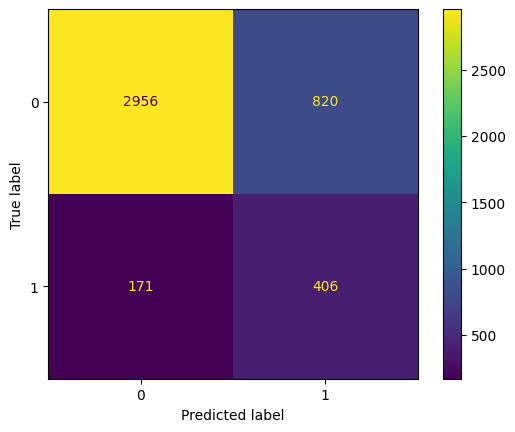

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth = 5)
dt.fit(df_anova, y)
pred = dt.predict(df_anova)
accuracy_score(pred, y)
mc = confusion_matrix(y, pred)

cm1_display = ConfusionMatrixDisplay(confusion_matrix = mc)
cm1_display.plot()
plt.show()

In [28]:
df_impo = pd.DataFrame()
df_impo['feature'] = dt.feature_names_in_
df_impo['importance'] = dt.feature_importances_.round(2)

In [29]:
px.bar(df_impo.sort_values(by = 'importance', ascending=False), x = 'feature', y='importance', text='importance')

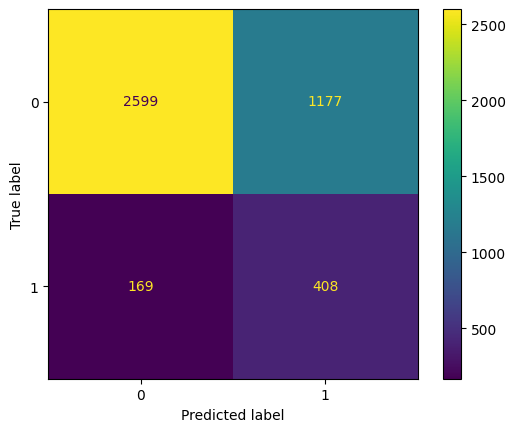

In [30]:
lg = LogisticRegression(class_weight='balanced', random_state=42)
lg.fit(df_anova, y)
pred = lg.predict(df_anova)
accuracy_score(pred, y)
mc = confusion_matrix(y, pred)

cm1_display = ConfusionMatrixDisplay(confusion_matrix = mc)
cm1_display.plot()
plt.show()

In [31]:
lg.feature_names_in_

array(['num__Age', 'num__MonthlyIncome', 'num__NumCompaniesWorked',
       'num__TrainingTimesLastYear', 'num__YearsAtCompany',
       'num__EnvironmentSatisfaction', 'num__JobSatisfaction',
       'num__WorkLifeBalance', 'num__JobInvolvement',
       'cat__StockOptionLevel_1', 'cat__StockOptionLevel_2',
       'cat__BusinessTravel_Non-Travel',
       'cat__BusinessTravel_Travel_Frequently',
       'cat__BusinessTravel_Travel_Rarely',
       'cat__Department_Human Resources', 'cat__Department_Sales',
       'cat__Education_College', 'cat__EducationField_Human Resources',
       'cat__EducationField_Other',
       'cat__EducationField_Technical Degree', 'cat__JobLevel_2',
       'cat__JobLevel_5', 'cat__JobRole_Manager',
       'cat__JobRole_Manufacturing Director',
       'cat__JobRole_Research Director',
       'cat__JobRole_Research Scientist', 'cat__JobRole_Sales Executive',
       'cat__MaritalStatus_Divorced', 'cat__MaritalStatus_Married',
       'cat__MaritalStatus_Single'], dtyp

In [32]:
lg.coef_.round(2)

array([[-0.43, -0.  ,  0.3 , -0.21, -0.34, -0.26, -0.35, -0.23, -0.04,
        -0.13,  0.17, -0.74,  0.81, -0.07,  0.81, -0.1 ,  0.24,  0.83,
        -0.37, -0.08,  0.11, -0.61, -0.46, -0.49,  0.46,  0.14,  0.3 ,
        -0.4 , -0.16,  0.56]])

In [33]:
df_impo = pd.DataFrame()
df_impo['feature'] = lg.feature_names_in_
df_impo['importance'] = lg.coef_.round(2)[0]

In [34]:
px.bar(df_impo.sort_values(by = 'importance', ascending=False), x = 'feature', y='importance', text='importance')

In [35]:
dt.feature_importances_

array([0.13638027, 0.07295771, 0.08015666, 0.04248941, 0.20114598,
       0.09171708, 0.09040263, 0.03346071, 0.        , 0.03327637,
       0.        , 0.        , 0.        , 0.        , 0.05710385,
       0.02340956, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.017849  , 0.        , 0.        ,
       0.        , 0.        , 0.03881588, 0.        , 0.08083489])

In [36]:
res_chi2= funciones.regresionLogistica(df_anova,y)

------------------------------ TRAIN ------------------------------
Precision: 0.25461847389558234
Recall: 0.6861471861471862
Especificidad: 0.6927152317880795
F1 score: 0.3714118336262449
Train score:  0.6918437679494543
------------------------------ TEST ------------------------------
Precision : 0.24702380952380953
Recall : 0.7217391304347827
Especificidad : 0.6653439153439153
F1 score : 0.36807095343680707
Test score:  0.6727898966704937


In [37]:
res_log=funciones.regresionLogistica(df_log,y)

------------------------------ TRAIN ------------------------------
Precision: 0.2619426751592357
Recall: 0.7121212121212122
Especificidad: 0.6930463576158941
F1 score: 0.3830034924330617
Train score:  0.6955772544514647
------------------------------ TEST ------------------------------
Precision : 0.25663716814159293
Recall : 0.7565217391304347
Especificidad : 0.6666666666666666
F1 score : 0.3832599118942731
Test score:  0.6785304247990815


In [38]:
res_ranfor=funciones.regresionLogistica(df_ranfor,y)

------------------------------ TRAIN ------------------------------
Precision: 0.2587185725871857
Recall: 0.6904761904761905
Especificidad: 0.6973509933774834
F1 score: 0.376401179941003
Train score:  0.6964388282596209
------------------------------ TEST ------------------------------
Precision : 0.2536873156342183
Recall : 0.7478260869565218
Especificidad : 0.6653439153439153
F1 score : 0.37885462555066085
Test score:  0.6762342135476463


In [39]:
res_ridge=funciones.regresionLogistica(df_ridge,y)

------------------------------ TRAIN ------------------------------
Precision: 0.24861000794281177
Recall: 0.6774891774891775
Especificidad: 0.6867549668874172
F1 score: 0.3637420104590355
Train score:  0.6855255600229753
------------------------------ TEST ------------------------------
Precision : 0.25146198830409355
Recall : 0.7478260869565218
Especificidad : 0.6613756613756614
F1 score : 0.3763676148796499
Test score:  0.6727898966704937


In [40]:
df3=df2.drop('target',axis=1)

In [41]:
res_all= funciones.regresionLogistica(df3,y)

------------------------------ TRAIN ------------------------------
Precision: 0.2734562951082598
Recall: 0.7380952380952381
Especificidad: 0.7
F1 score: 0.39906377998829723
Train score:  0.7050545663411832
------------------------------ TEST ------------------------------
Precision : 0.25075528700906347
Recall : 0.7217391304347827
Especificidad : 0.671957671957672
F1 score : 0.3721973094170404
Test score:  0.6785304247990815


Comparando los desempeños de cada de los modelos evaluados de selección de variables, se decide utilizar el de las mejoras metricas centransonos mas que todo en el recall pero sin dejar caer mucho la presición, por ello se ha seleccionado trabajar con el conjunto de caracteristicas de SelectKBest con la prueba de anova

In [42]:
df_anova.to_csv('Data/seleccion_anova.csv', index = False)
df2.to_csv('Data/base_target.csv', index = False)

# modelos con hiperparametros


### anova

In [68]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

In [69]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth = 5)
# Inicializar GridSearchCV con el clasificador 
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar a los datos de entreno
grid_search.fit(df_anova, y)

print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [70]:
# Obtener modelo
best_dt = grid_search.best_estimator_
pred = best_dt.predict(df_anova)

accuracy = accuracy_score(y, pred)
print("Precisión del mejor modelo:", accuracy)

Precisión del mejor modelo: 0.9503790489317712


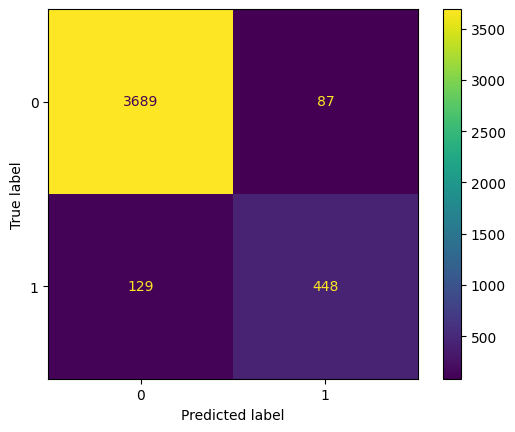

In [71]:
mc = confusion_matrix(y, pred)
cm1_display = ConfusionMatrixDisplay(confusion_matrix=mc)
cm1_display.plot()
plt.show()


### Regresión logistica

In [ ]:
#f_anova = pd.read_csv('Datasets/seleccion_anova.csv')
#df_total = pd.read_csv('Data/base_target.csv')